## Tuning model parameters to match a firing rate

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme("notebook")
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj

import sys
sys.path.append("..")

from spikeometric.models import RectifiedLNP
from spikeometric.datasets import MexicanHatGenerator
from spikeometric.stimulus import SinStimulus

In this example we will show how to tune a model to a given firing rate. We will use the RectifiedLNP model,
but the same procedure can be applied to any other differentiable model. 

The RectifiedLNP model is taken from the paper
[Systematic errors in connectivity inferred from activity in strongly coupled recurrent circuits](https://www.biorxiv.org/content/10.1101/512053v1.full)
and in the paper it is hand-tuned to get an interspike interval of 16 ms. We will show how to do this automatically using snn-glm-simulator.

### Preparing the training data
We start by making some networks that we want to fit the model on. We will use 24 networks of 100 neurons each, with the neurons organized in a ring network with inhibitory weights following a mexican hat shape.

In [2]:
# Create a dataset of connectivity matrices to train on
n_neurons = 100
n_networks = 5

dataset = MexicanHatGenerator(100, a=1.0015, sigma_1=6.98, sigma_2=7.).generate(n_networks)

data_loader = DataLoader(dataset, batch_size=5, shuffle=True)

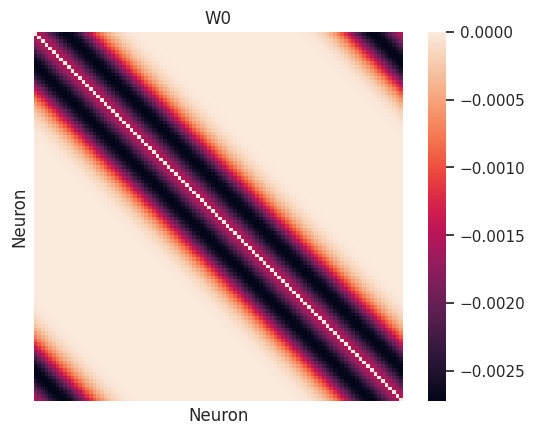

In [3]:
# Plot the first connectivity matrix
square_W0 = to_dense_adj(dataset[0].edge_index, edge_attr=dataset[0].W0, max_num_nodes=dataset[0].num_nodes)[0]
sns.heatmap(square_W0, square=True, xticklabels=False, yticklabels=False)
plt.title("W0")
plt.xlabel("Neuron")
plt.ylabel("Neuron")
plt.show()

### The Rectified Linear-Nonlinear-Poisson model
In the `RectifiedLNP` model, neurons are subject to a uniform background input $b$ in addition to the recurrent synaptic input from neighbors, weighted by $r$. Spikes from neighboring neurons are filtered by an exponential decay with a time constant $\tau$. For each time step, spikes are sampled from a Poisson distribution after passing the input through a thresholded scaled rectifier.

$$g_i(t+1) = \sum_{j \in \mathcal{N}(i)} \mathbf{W}_{j, i} \cdot \mathbf{x}_j(t) + b$$
$$\mu_i(t+1) = \lambda_0 [g_i(t+1) - \theta]_+$$ 
$$ x_i(t+1) \sim \text{Pois}(\mu_i(t+1))$$

In [4]:
model = RectifiedLNP(
    lambda_0 = 100.,
    theta = 5e-5,
    T=20,
    tau=10.,
    dt=0.1,
    r=0.025,
    b=0.0013
)

Let's see what kind of behaviour these parameters lead to by simulating the model on the test set for one network-second.

In [5]:
results = torch.zeros((n_neurons*len(dataset)), 1000)
for i, data in enumerate(data_loader):
    results[i*data.num_nodes:(i+1)*data.num_nodes] = model.simulate(data, n_steps=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:01<00:00, 835.90it/s]


In [6]:
# Calculate firing rate and ISI
fr = results.float().mean()
isi = model.dt/fr

print("Average firing rate: ", (fr/model.dt).item()*1000, "Hz")
print("Average ISI: ", isi.item(), "ms")

Average firing rate:  94.11999583244324 Hz
Average ISI:  10.624734878540039 ms


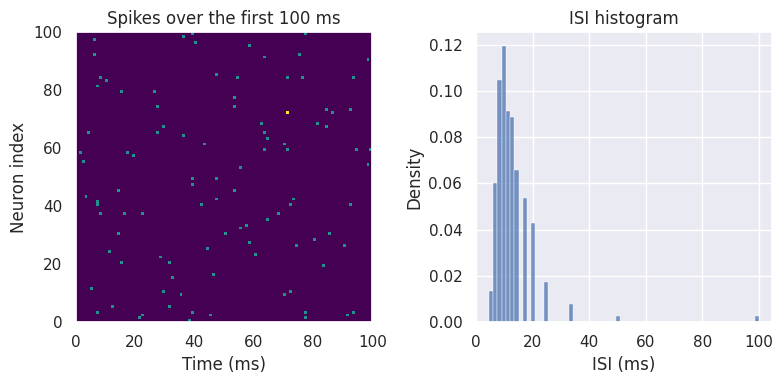

In [7]:
isi = model.dt / (results.float().mean(dim=1))

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].pcolormesh(results[:n_neurons, :100], cmap="viridis")
ax[0].set_xlabel("Time (ms)")
ax[0].set_ylabel("Neuron index")
ax[0].set_title("Spikes over the first 100 ms")

sns.histplot(isi, ax=ax[1], stat="density")
ax[1].set_ylabel("Density")
ax[1].set_xlabel("ISI (ms)")
ax[1].set_title("ISI histogram")

plt.tight_layout()
plt.show()

We see that, on average, there is a bit too much activity. The models are tuned using a target firing rate, so let's first convert the ISI of 16 ms to a firing rate, and then tune the value of $\theta$ to match it.

In [8]:
target_fr = 1000 / 16 # 1 second / 16 ms = 62.5 Hz
for i, data in enumerate(data_loader):
    model.tune(data, firing_rate=target_fr, n_steps=100, lr=1e-4, n_epochs=100)

Tuning... fr=62.45401: 100%|██████████| 100/100 [00:27<00:00,  3.69it/s]


Let's see how the model performs on the test set:

In [9]:
test_results = torch.zeros(n_neurons*len(dataset), 10000)
for i, data in enumerate(data_loader):
    test_results[i*data.num_nodes:(i+1)*data.num_nodes] = model.simulate(data, n_steps=10000)

100%|██████████| 10000/10000 [00:10<00:00, 971.58it/s]


In [10]:
new_fr =  test_results.float().mean()
new_isi = 1/new_fr

print("New firing rate: ", (new_fr/model.dt).item() * 1000, "Hz")
print("New ISI: ", (new_isi*model.dt).item(), "ms")

New firing rate:  67.83399730920792 Hz
New ISI:  14.741869926452637 ms


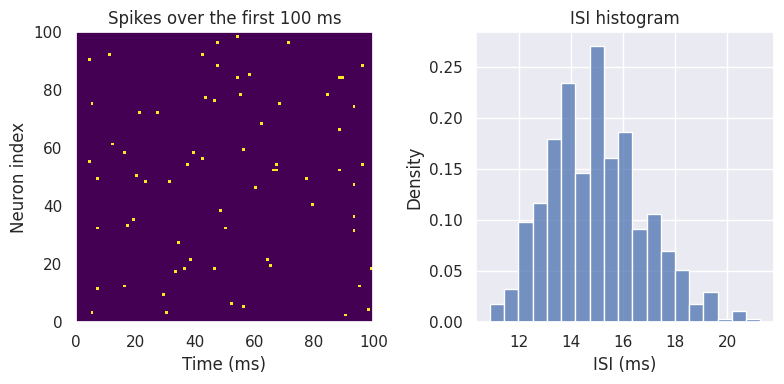

In [11]:
isi = model.dt / (test_results.float().mean(dim=1))

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].pcolormesh(test_results[:n_neurons, :100], cmap="viridis")
ax[0].set_xlabel("Time (ms)")
ax[0].set_ylabel("Neuron index")
ax[0].set_title("Spikes over the first 100 ms")

sns.histplot(isi, ax=ax[1], stat="density")
ax[1].set_ylabel("Density")
ax[1].set_xlabel("ISI (ms)")
ax[1].set_title("ISI histogram")

plt.tight_layout()
plt.show()

This is just what we wanted!

That's the end of this tutorial! If you want to know how we can tune stimulus as well, you can find an example in `working_with_stimulus.ipynb`.